## XGBoost Notes
**Ayush Noori**

This file contains notes and tests for training an XGBoost model **outside** of an Optuna loop. These tests were used to write `train_xgboost.ipynb`. Please see that file for the final version of the code.

First, I load the relevant libraries.

In [1]:
# import base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # inline plots
%matplotlib inline

# TDC library
from tdc.benchmark_group import admet_group
from tdc.chem_utils import MolConvert

# XGBoost
import xgboost as xgb

# import Optuna
import optuna
from optuna.samplers import TPESampler
import optuna.visualization.matplotlib as oviz

# logging to show Optuna output
import logging
import sys

# time management
from datetime import datetime

# create time object used for file names
my_time = datetime.now()

In [2]:
group = admet_group(path = 'data/')
predictions_list = []

Found local copy...


Next, I retrieve the data.

In [3]:
# set seed and benchmark in benchmark
seed = 1
benchmark = group.get('BBB_Martins') 
    
# all benchmark names in a benchmark group are stored in group.dataset_names
predictions = {}
name = benchmark['name']
train_val, test = benchmark['train_val'], benchmark['test']
# train, valid = group.get_train_valid_split(benchmark = name, split_type = 'default', seed = seed)

First, I check the eligible conversions.

In [4]:
MolConvert.eligible_format(src = "SMILES")

['SELFIES',
 'Graph2D',
 'PyG',
 'DGL',
 'ECFP2',
 'ECFP4',
 'ECFP6',
 'MACCS',
 'Daylight',
 'RDKit2D',
 'Morgan',
 'PubChem']

I train the model using `train` and `valid` variables, evaluate on the `test` variable, then save the `test` predictions in `y_pred_test`. First, I convert the SMILES structures to fingerprints. Note that conversion from `SMILES` to `RDKit2D` requires `pip install git+https://github.com/bp-kelley/descriptastorus` and `pip install pandas-flavor`.

In [16]:
# define fingerprint
mol_dst = 'RDKit2D'
# mol_dst = trial.suggest_categorical("mol_dst", ["ECFP2", "ECFP4", "MACCS", "Morgan", "Daylight", "RDKit2D"])

# convert fingerprint
converter = MolConvert(src = 'SMILES', dst = mol_dst)
train_val_features = pd.DataFrame([converter(x) for x in train_val['Drug'][0:5]])
# test_features = pd.DataFrame([converter(x) for x in test['Drug']])
train_val_features.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.921082,0.077700,0.324169,0.379878,0.467164,0.240353,0.344156,0.422452,0.438361,0.462373,...,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.322648
1,0.987144,0.031450,0.012150,0.007312,0.016454,0.007969,0.006128,0.010915,0.009768,0.020255,...,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.790579
2,0.952163,0.031338,0.040727,0.064078,0.045419,0.025158,0.042085,0.026486,0.113303,0.068544,...,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.858166
3,0.954015,0.038479,0.025235,0.013677,0.008824,0.020597,0.013406,0.008540,0.011734,0.005801,...,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.575999
4,0.950627,0.115216,0.268876,0.252717,0.271183,0.201013,0.178351,0.288253,0.140577,0.198425,...,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.490319


Next, I convert the datasets into an optimized data structure called `DMatrix` that XGBoost supports for performance and efficiency gains.

In [7]:
# define the optimized DMatrix object
dtrain_val = xgb.DMatrix(train_val_features, label = train_val['Y'])
dtest = xgb.DMatrix(test_features, label = test['Y'])

The parameter definition code below was inspired by [this post](https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407) with [this source code](https://gist.github.com/Crissman/4ddeec6718627ecef46f863e1bf90424#file-xgboost_integration-py). See [the documentation](https://xgboost.readthedocs.io/en/latest/parameter.html) for a full list of possible parameters.

In [ ]:
# define the XGBoost parameters

# params = {
#         "objective": "binary:logistic",
#         "eval_metric": "auc",
#         "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
#         "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
#         "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
#     }

# if params["booster"] == "gbtree" or params["booster"] == "dart":
#     params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
#     params["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
#     params["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
#     params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

# if params["booster"] == "dart":
#     params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
#     params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
#     params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
#     params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)


Outside of an Optuna trial, use the following code.

In [77]:
params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "lambda": 1e-6,
        "alpha": 1e-6,
        "max_depth": 4,
        # "eta": 1e-6,
        # "gamma": 1e-6,
        "grow_policy": "depthwise"
    }

Finally, I define the XGBoost regressor and train the model using 5-fold cross-validation. The `xgb.cv()` function returns the evaluation history; i.e., the last boosting round metric is the best.

In [61]:
# perform cross-validation
cv_results = xgb.cv(dtrain = dtrain_val, params = params, nfold = 5, \
    num_boost_round = 100, early_stopping_rounds = 10, metrics = "auc", as_pandas = True, seed = seed)
cv_results.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
37,0.983556,0.002102,0.900754,0.010689
38,0.984199,0.002078,0.901658,0.010538
39,0.984733,0.001969,0.902352,0.010570
40,0.985151,0.002021,0.903249,0.010432
41,0.985599,0.001994,0.905091,0.010178


In [75]:
# train final model based on parameters in Optuna trial
xgb_model = xgb.train(dtrain = dtrain_val, params = params, num_boost_round = 50)

[14:52:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "grow_policy", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [42]:
# report the final boosting metric as the summary metric for this Optuna trial
test_auc_mean = cv_results["test-auc-mean"].tail(1)
test_auc_mean

# in Optuna loop
# return xgb_model, test_auc_mean

41    0.905091
Name: test-auc-mean, dtype: float64

The code below is for an Optuna loop - do not run!

In [54]:
# define training function
def train_xgboost(trial):

    return xgb_model, test_auc_mean

Define Optuna `objective` function.

In [90]:
# define directories
optuna_dir = "optuna/"
model_dir = optuna_dir + "models/"
study_dir = optuna_dir + "database/"

# define objective function
def objective(trial):

    # start the training loop
    trial_xgb_model, trial_test_auc_mean = train_xgboost(trial)

    # save model for this loop
    trial_xgb_model.save_model(model_dir + "xgboost_model_{}.json".format(trial.number))

    return trial_test_auc_mean

Run Optuna trials.

In [92]:
# add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

# create study
study_name = "xgboost-study"  # unique identifier of the study
storage_name = "sqlite:///{}.db".format(study_dir + study_name)
study = optuna.create_study(direction = "maximize", sampler = TPESampler(seed = 1234, multivariate = True), study_name = study_name, storage = storage_name, load_if_exists = False)

# optimize hyperparameters
study.optimize(objective, n_trials = 3, gc_after_trial = True)

[I 2022-05-04 14:55:48,669] A new study created in RDB with name: xgboost-study


A new study created in RDB with name: xgboost-study
A new study created in RDB with name: xgboost-study
A new study created in RDB with name: xgboost-study
A new study created in RDB with name: xgboost-study
A new study created in RDB with name: xgboost-study
A new study created in RDB with name: xgboost-study
A new study created in RDB with name: xgboost-study
A new study created in RDB with name: xgboost-study
A new study created in RDB with name: xgboost-study


[I 2022-05-04 14:55:48,877] Trial 0 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.


Trial 0 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 0 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 0 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 0 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 0 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 0 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 0 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 0 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 0 finished with value: 0.9050908308634998 and parameters: {}. Best

[I 2022-05-04 14:55:49,245] Trial 1 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.


Trial 1 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 1 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 1 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 1 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 1 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 1 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 1 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 1 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 1 finished with value: 0.9050908308634998 and parameters: {}. Best

[I 2022-05-04 14:55:49,627] Trial 2 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.


Trial 2 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 2 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 2 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 2 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 2 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 2 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 2 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 2 finished with value: 0.9050908308634998 and parameters: {}. Best is trial 0 with value: 0.9050908308634998.
Trial 2 finished with value: 0.9050908308634998 and parameters: {}. Best

After training, I output Optuna results.

In [93]:
# get pruned and complete trials
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# print print study statistics
print("\nStudy Statistics:")
print("- Finished Trials: ", len(study.trials))
print("- Pruned Trials: ", len(pruned_trials))
print("- Complete Trials: ", len(complete_trials))

print("\nBest Trial:")
best_trial = study.best_trial
print("- Number: ", best_trial.number)
print("- Value: ", best_trial.value)
print("- Hyperparameters: ")
for key, value in best_trial.params.items():
    print("   - {}: {}".format(key, value))

# save and view output
study_results = study.trials_dataframe(attrs=("number", "value", "params", "state"))
study_results.to_csv(optuna_dir + "{}.{}_{}.{}.{}_OptunaHistory.csv".format(my_time.hour, my_time.minute, my_time.month, my_time.day, my_time.year))


Study Statistics:
- Finished Trials:  3
- Pruned Trials:  0
- Complete Trials:  3

Best Trial:
- Number:  0
- Value:  0.9050908308634998
- Hyperparameters: 


I visualize Optuna trial results.

In [ ]:
v1 = oviz.plot_param_importances(study)
v2 = oviz.plot_optimization_history(study)
v3 = oviz.plot_slice(study)

def fig_name(name):
    return(optuna_dir + "output/" + "{}.{}_{}.{}.{}_{}.pdf".format(my_time.hour, my_time.minute, my_time.month, my_time.day, my_time.year, name))

v1.figure.savefig(fig_name("HyperparameterImportance"))
v2.figure.savefig(fig_name("OptimizationHistory"))

Finally, I train a new model based on the best trial.

In [101]:
# train new model based on the best trial
best_xgb_model = xgb.Booster()
best_xgb_model.load_model(model_dir + "xgboost_model_{}.json".format(best_trial.number))

Now, I evaluate on the independent test set.

(array([ 88.,  12.,   7.,  10.,   2.,   5.,  11.,   5.,  12., 254.]),
 array([3.3818278e-11, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

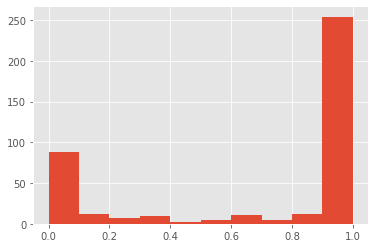

In [103]:
# evaluate on test set
y_pred_test = best_xgb_model.predict(dtest)
plt.hist(y_pred_test)

Finally, I append the predictions to the `predictions_list` object.

In [104]:
predictions[name] = y_pred_test
predictions_list.append(predictions)